# Dask for Parallel Computing in Python

In past lectures, we learned how to use numpy, pandas, and xarray to analyze various types of geoscience data.
In this lecture, we address an incresingly common problem: what happens if the data we wish to analyze is "big data"

### Aside: What is "Big Data"?

There is a lot of hype around the buzzword "big data" today.
Some people may associate "big data" with specific sortware platforms (e.g. "Hadoop", "spark"), while, for others, "big data" means specific machine learning techniques.
But I think [wikipedia's definition](https://en.wikipedia.org/wiki/Big_data) is the most useful

> Big data is data sets that are so voluminous and complex that traditional data processing application software are inadequate to deal with them.

By this definition, a great many datasets we regularly confront in Earth science are big data.

A good threshold for when data becomes difficult to deal with is when the volume of data exceeds your computer's RAM. Most modern laptops have between 2 and 16 GB of RAM. High-end workstations and servers can have 1 TB (1000 GB) or RAM or more. If the dataset you are trying to analyze can't fit in you computer's memory, some special care is required to carry out the analysis. Data that can't fit in RAM but can fit on your hard drive is sometimes called "medium data."

The next threshold of difficulty is when the data can't fit on your hard drive. Most modern laptops have between 100 GB and 4 TB of storage space on the hard drive. If you can't fit your dataset on your internal hard drive, you can buy an external hard drive. However, at that point you are better off using a high-end server, HPC system, or cloud-based storage for your dataset. Once you have many TB of data to analyze, you are definitely in the realm of "big data"

### What is Dask?

Dask is a tool that helps us easily extend our familiar python data analysis tools to medium and big data, i.e. dataset that can't fit in our computer's RAM. In many cases, dask also allows us to speed up our analysis by using mutiple CPU cores. Dask can help us work more efficiently on our laptop, and it can also help us scale up our analysis on HPC and cloud platforms. Most importantly, dask is almost invisible to the user, meaning that you can focus on your science, rather than the details of parallel computing.

Dask was created by the brilliant [Matt Rocklin](http://matthewrocklin.com/). You can learn more about it on

* [The Dask Documentation](http://dask.readthedocs.io/en/latest/)
* [The Dask Github Site](https://github.com/dask/dask)

Dask provides _collections for big data_ and _a scheduler for parallel computing_. It is probably easiest to illustrate what these mean through examples, so we will jump right in.

## Dask Arrays

A dask array looks and feels a lot like a numpy array.
However, a dask array doesn't directly hold any data.
Instead, it symbolically represents the computations needed to generate the data.
Nothing is actually computed until the actual numerical values are needed.
This mode of operation is called "lazy"; it allows one to build up complex, large calculations symbolically before turning them over the scheduler for execution.

If we want to create a numpy array of all ones, we do it like this:

In [14]:
import numpy as np
shape = (1000, 4000)
ones_np = np.ones(shape)
ones_np

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

This array contains exactly 32 MB of data:

In [2]:
ones_np.nbytes / 1e6

32.0

Now let's create the same array using dask's array interface.

In [3]:
import dask.array as da
ones = da.ones(shape)

ValueError: You must specify a chunks= keyword argument.
This specifies the chunksize of your array blocks.

See the following documentation page for details:
  http://dask.pydata.org/en/latest/array-creation.html#chunks

This did not work, because we didn't tell dask how to split up the array.

A crucal difference with dask is that we must specify the `chunks` argument. "Chunks" describes how the array is split up over many sub-arrays.

![Dask Arrays](http://dask.pydata.org/en/latest/_images/dask-array-black-text.svg)
_source: [Dask Array Documentation](http://dask.pydata.org/en/latest/array-overview.html)_

There are [several ways to specify chunks](http://dask.pydata.org/en/latest/array-creation.html#chunks).
In this lecture, we will use a block shape.

In [4]:
chunk_shape = (1000, 1000)
ones = da.ones(shape, chunks=chunk_shape)
ones

dask.array<wrapped, shape=(1000, 4000), dtype=float64, chunksize=(1000, 1000)>

Notice that we just see a symbolic represetnation of the array, including its shape, dtype, and chunksize.
No data has been generated yet.
When we call `.compute()` on a dask array, the computation is trigger and the dask array becomes a numpy array.

In [5]:
ones.compute()

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

In order to understand what happened when we called `.compute()`, we can visualize the dask _graph_, the symbolic operations that make up the array

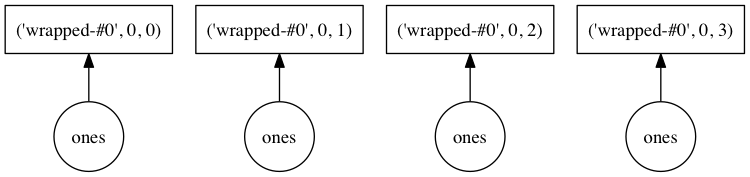

In [6]:
ones.visualize()

Our array has four chunks. To generate it, dask calls `np.ones` four times and then concatenates this together into one array.

Rather than immediately loading a dask array (which puts all the data into RAM), it is more common to want to reduce the data somehow. For example

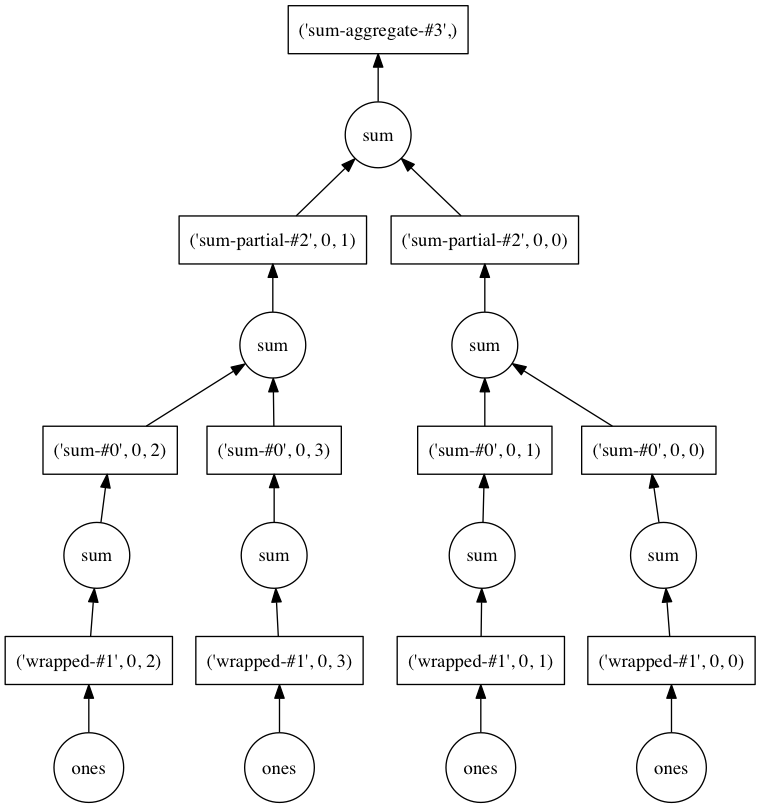

In [7]:
sum_of_ones = ones.sum()
sum_of_ones.visualize()

Here we see dask's strategy for finding the sum. This simple example illustrates the beauty of dask: it automatically designs an algorithm appropriate for custom operations with big data. 

If we make our operation more complex, the graph gets more complex.

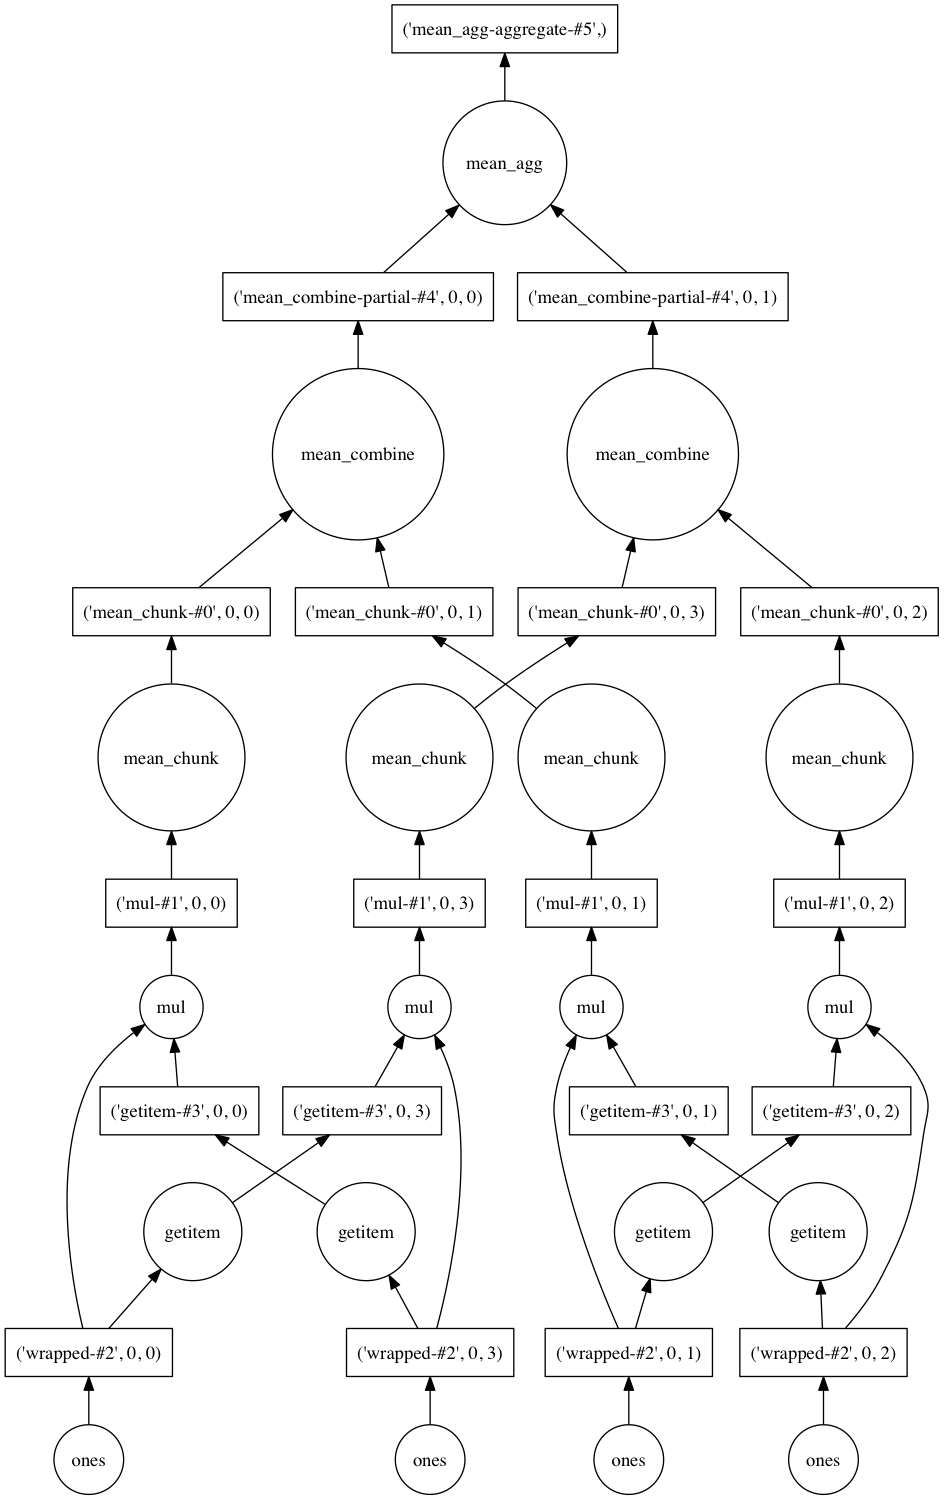

In [8]:
fancy_calculation = (ones * ones[::-1, ::-1]).mean()
fancy_calculation.visualize()

### A Bigger Calculation

The examples above were toy examples; the data (32 MB) is nowhere nearly big enough to warrant the use of dask.

We can make it a lot bigger!

In [9]:
bigshape = (200000, 4000)
big_ones = da.ones(bigshape, chunks=chunk_shape)
big_ones

dask.array<wrapped, shape=(200000, 4000), dtype=float64, chunksize=(1000, 1000)>

In [10]:
big_ones.nbytes / 1e6

6400.0

This dataset is 3.2 GB, rather MB! This is probably close to or greater than the amount of available RAM than you have in your computer. Nevertheless, dask has no problem working on it.

_Do not try to `.visualize()` this array!_

When doing a big calculation, dask also has some tools to help us understand what is happening under the hood

In [11]:
from dask.diagnostics import ProgressBar

big_calc = (big_ones * big_ones[::-1, ::-1]).mean()

with ProgressBar():
    result = big_calc.compute()
result

[########################################] | 100% Completed |  7.3s


1.0

### Reduction 

All the usual numpy methods work on dask arrays.
You can also apply numpy function directly to a dask array, and it will stay lazy.

In [12]:
big_ones_reduce = (np.cos(big_ones)**2).mean(axis=0)
big_ones_reduce

dask.array<mean_agg-aggregate, shape=(4000,), dtype=float64, chunksize=(1000,)>

Plotting also triggers computation, since we need the actual values

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)

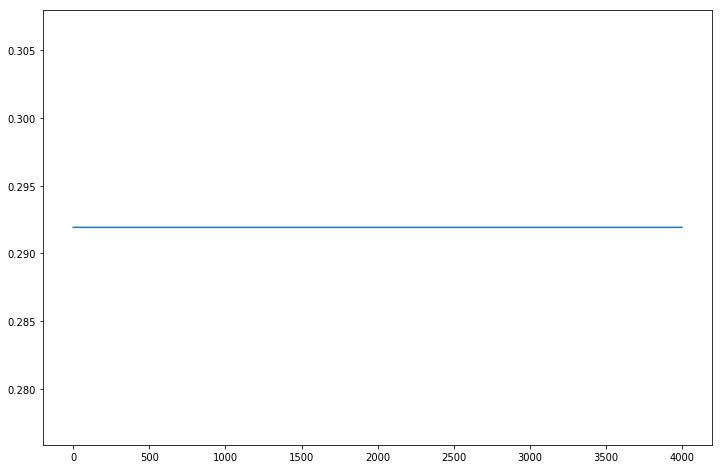

In [13]:
plt.plot(big_ones_reduce)

### Distributed Cluster

For more fancy visualization of what dask is doing, we can use the [distributed scheduler](https://distributed.readthedocs.io/en/latest/).


In [1]:
from dask.distributed import Client, LocalCluster

In [2]:
lc = LocalCluster(n_workers=1)
client = Client(lc)
client

Client Scheduler: tcp://127.0.0.1:50706 Dashboard: http://127.0.0.1:8787,Cluster Workers: 1 Cores: 4 Memory: 8.59 GB


In [16]:
big_calc.compute()

1.0

In [17]:
random_values = da.random.normal(size=(2e8,), chunks=(1e6,))
hist, bins = da.histogram(random_values, bins=100, range=[-5, 5]) 

In [18]:
hist

dask.array<sum-aggregate, shape=(100,), dtype=int64, chunksize=(100,)>

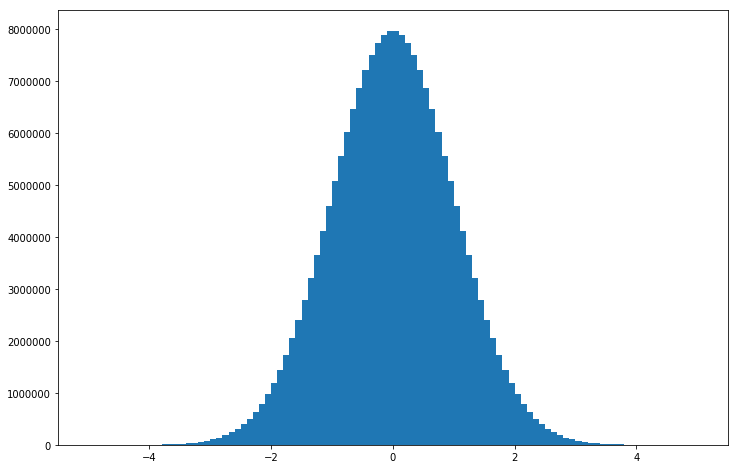

In [19]:
x = 0.5 * (bins[1:] + bins[:-1])
width = np.diff(bins)
plt.bar(x, hist, width);

## Dask + XArray

Xarray can automatically wrap its data in dask arrays.
This capability turns xarray into an extremely powerful tool for Big Data earth science

To see this in action, we will download a fairly large dataset to analyze. This file contains 1 year of daily data from the [AVISO](http://www.aviso.oceanobs.com/en/data/products/index.html)
sea-surface height satellite altimetry dataset.

In [20]:
! curl -O http://www.ldeo.columbia.edu/~rpa/aviso_madt_2015.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 38  471M   38  180M    0     0  10.5M      0  0:00:44  0:00:17  0:00:27 8856k:30 11.7M^C


In [ ]:
! tar -xvzf aviso_madt_2015.tar.gz

In [22]:
! ls 2015 | wc -l

     365


Let's load the first file as a regular xarray dataset.

In [3]:
import xarray as xr
xr.__version__

'0.10.0-52-gd8842a6'

In [24]:
ds_first = xr.open_dataset('2015/dt_global_allsat_madt_h_20150101_20150914.nc')
ds_first

<xarray.Dataset>
Dimensions:   (lat: 720, lon: 1440, nv: 2, time: 1)
Coordinates:
  * time      (time) datetime64[ns] 2015-01-01T00:01:44.499838976
  * lat       (lat) float32 -89.875 -89.625 -89.375 -89.125 -88.875 -88.625 ...
  * lon       (lon) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875 ...
  * nv        (nv) int32 0 1
Data variables:
    lat_bnds  (lat, nv) float32 ...
    lon_bnds  (lon, nv) float32 ...
    crs       int32 ...
    adt       (time, lat, lon) float64 ...
Attributes:
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Absolute Dynamic Topography
    contact:                         aviso@altimetry.fr
    creator_email:                   aviso@altimetry.fr
    creator_name:                    SSALTO/DUACS
    creator_url:                     http://www.aviso.altimetry.fr
    date_created:                    2015-10-23T

In [25]:
ds_first.nbytes / 1e6

8.32034

This one file is about 8 MB. So 365 of them will be nearly 3 GB. If we had downloaded all 25 years of data, it would be 73 GB. This is a good example of "medium data."

### open_mfdataset

An incredibly useful function in xarray is `open_mfdataset`.

In [26]:
help(xr.open_mfdataset)

Help on function open_mfdataset in module xarray.backends.api:

open_mfdataset(paths, chunks=None, concat_dim='__infer_concat_dim__', compat='no_conflicts', preprocess=None, engine=None, lock=None, data_vars='all', coords='different', **kwargs)
    Open multiple files as a single dataset.
    
    Requires dask to be installed.  Attributes from the first dataset file
    are used for the combined dataset.
    
    Parameters
    ----------
    paths : str or sequence
        Either a string glob in the form "path/to/my/files/*.nc" or an explicit
        list of files to open.  Paths can be given as strings or as pathlib
        Paths.
    chunks : int or dict, optional
        Dictionary with keys given by dimension names and values given by chunk
        sizes. In general, these should divide the dimensions of each dataset.
        If int, chunk each dimension by ``chunks``.
        By default, chunks will be chosen to load entire input files into
        memory at once. This has a ma

Using `open_mfdataset` we can easily open all the netcdf files into one `Dataset` object.

In [4]:
# On I got a "Too many open files" OSError.
# It's only 365 files. That shouldn't be too many. 
# However, I discovered my ulimit was extremely low.
# One workaround is to call 
#  $ ulimit -S -n 4000
# from the command line before launching the notebook

ds = xr.open_mfdataset('2015/*.nc')
ds

<xarray.Dataset>
Dimensions:   (lat: 720, lon: 1440, nv: 2, time: 365)
Coordinates:
  * lat       (lat) float32 -89.875 -89.625 -89.375 -89.125 -88.875 -88.625 ...
  * lon       (lon) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875 ...
  * nv        (nv) int32 0 1
  * time      (time) datetime64[ns] 2015-01-01T00:01:44.499838976 ...
Data variables:
    lat_bnds  (time, lat, nv) float32 dask.array<shape=(365, 720, 2), chunksize=(1, 720, 2)>
    lon_bnds  (time, lon, nv) float32 dask.array<shape=(365, 1440, 2), chunksize=(1, 1440, 2)>
    crs       (time) int32 -2147483647 -2147483647 -2147483647 -2147483647 ...
    adt       (time, lat, lon) float64 dask.array<shape=(365, 720, 1440), chunksize=(1, 720, 1440)>
Attributes:
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Absolute Dynamic Topography
    contact:                         aviso@

Note that the values are not displayed, since that would trigger computation.

In [5]:
ssh = ds.adt
ssh

<xarray.DataArray 'adt' (time: 365, lat: 720, lon: 1440)>
dask.array<shape=(365, 720, 1440), dtype=float64, chunksize=(1, 720, 1440)>
Coordinates:
  * lat      (lat) float32 -89.875 -89.625 -89.375 -89.125 -88.875 -88.625 ...
  * lon      (lon) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875 ...
  * time     (time) datetime64[ns] 2015-01-01T00:01:44.499838976 ...
Attributes:
    grid_mapping:   crs
    long_name:      Absolute Dynamic Topography
    standard_name:  sea_surface_height_above_geoid
    units:          m

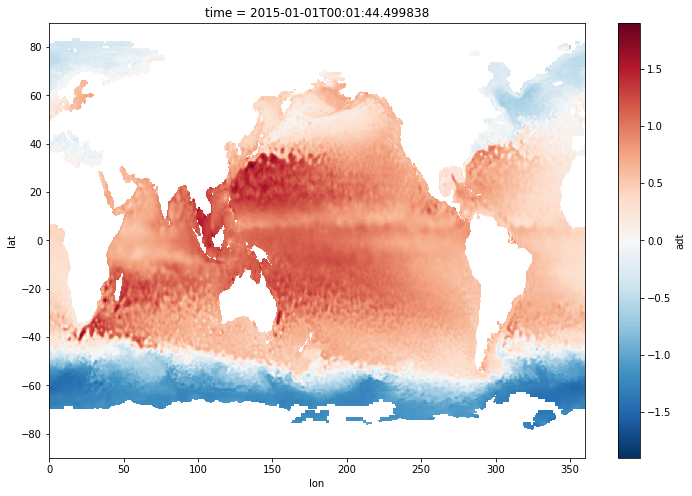

In [8]:
ssh[0].plot()

In [9]:
ssh_2015_mean = ssh.mean(dim='time')
ssh_2015_mean.load()

<xarray.DataArray 'adt' (lat: 720, lon: 1440)>
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])
Coordinates:
  * lat      (lat) float32 -89.875 -89.625 -89.375 -89.125 -88.875 -88.625 ...
  * lon      (lon) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875 ...

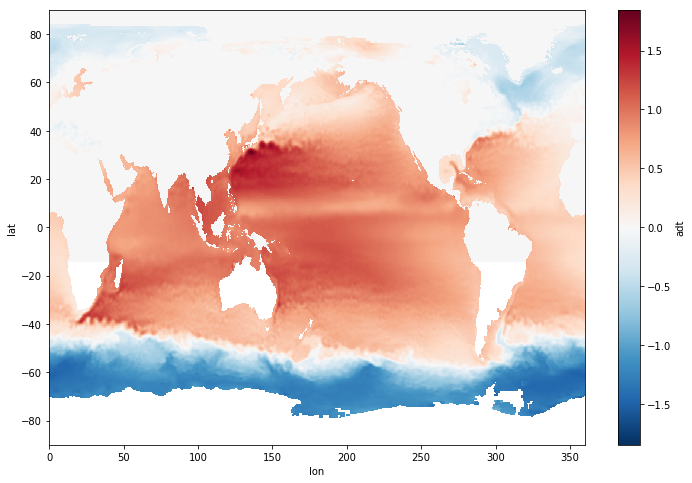

In [10]:
ssh_2015_mean.plot()

In [11]:
ssh_anom = ssh - ssh_2015_mean
ssh_variance_lonmean = (ssh_anom**2).mean(dim=('lon', 'time'))

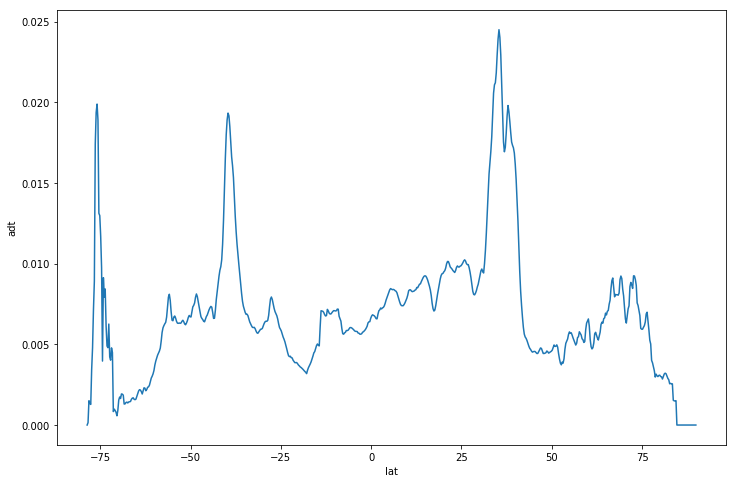

In [12]:
ssh_variance_lonmean.plot()

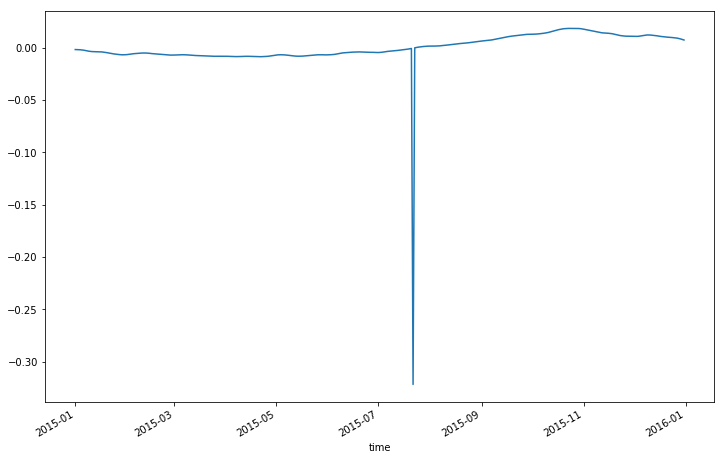

In [15]:
weight = np.cos(np.deg2rad(ds.lat))
weight /= weight.mean()
(ssh_anom * weight).mean(dim=('lon', 'lat')).plot()